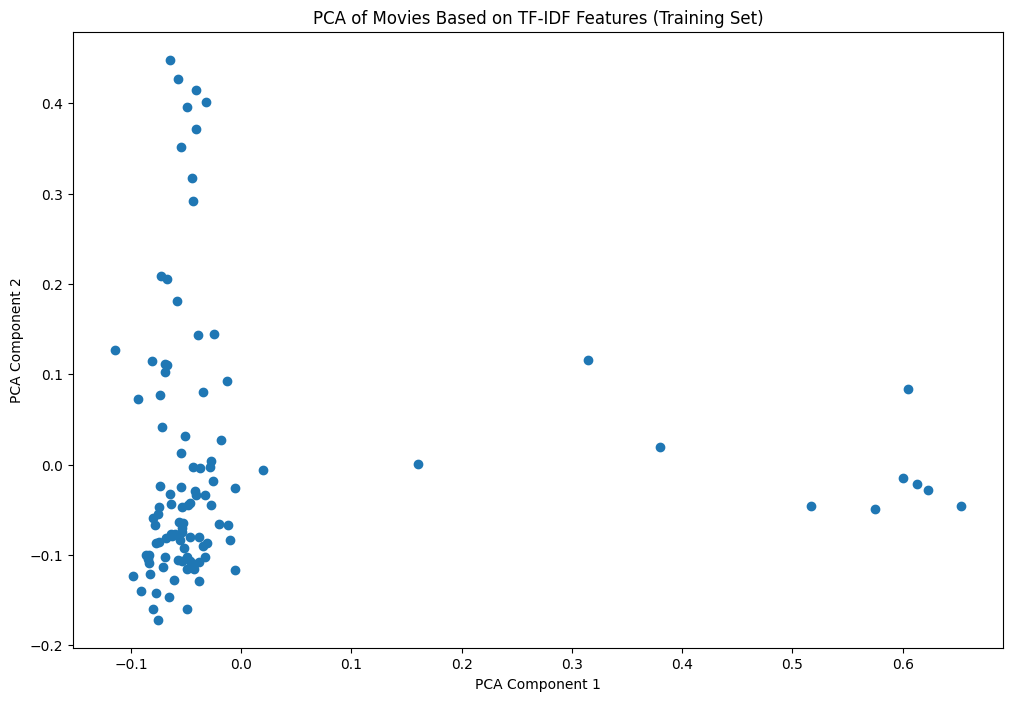


Recommended Movies (Training Set):
                                              title  IMDB_Score  Won_Oscar  \
41                                             Jaws         0.0       True   
392                                Django Unchained         0.0       True   
5203                              The Hateful Eight         0.0       True   
8405          The Lord of the Rings: The Two Towers         0.0       True   
8120                                        Sunrise         0.0       True   
...                                             ...         ...        ...   
7330                                    Logan's Run         0.0       True   
7073           Indiana Jones and the Temple of Doom         0.0       True   
1251                             Dances with Wolves         0.0       True   
8404  The Lord of the Rings: The Return of the King         0.0       True   
6056                                   A Separation         0.0       True   

                           

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load datasets
netflix_titles = pd.read_csv('C:/Users/90538/Desktop/Machine Learning/netflix_titles.csv')
oscar = pd.read_csv('C:/Users/90538/Desktop/Machine Learning/oscar.csv')
imdb_data = pd.read_csv('C:/Users/90538/Desktop/Machine Learning/imdb_data.csv')

# Merge netflix_titles with oscar data
netflix_titles_oscar = pd.merge(netflix_titles, oscar, left_on='title', right_on='Film', how='left')
netflix_titles_oscar['Won_Oscar'] = netflix_titles_oscar['Award'].notna()

# Merge the resulting dataframe with imdb_data
netflix_titles_imdb = pd.merge(netflix_titles_oscar, imdb_data, left_on='title', right_on='Name', how='left')

# Rename the 'Rating' column to 'IMDB_Score'
netflix_titles_imdb.rename(columns={'Rating': 'IMDB_Score'}, inplace=True)

# Convert 'IMDB_Score' to numeric and handle errors
netflix_titles_imdb['IMDB_Score'] = pd.to_numeric(netflix_titles_imdb['IMDB_Score'], errors='coerce')

# Handle NaN values in IMDB_Score by filling them with 0
netflix_titles_imdb['IMDB_Score'] = netflix_titles_imdb['IMDB_Score'].fillna(0)

# Filter movies with IMDB score above 7 or won an Oscar
filtered_movies = netflix_titles_imdb.loc[
    (netflix_titles_imdb['IMDB_Score'] > 7) | (netflix_titles_imdb['Won_Oscar'])
].copy()

# Combine 'description' and 'listed_in' for TF-IDF
filtered_movies['combined_features'] = filtered_movies['description'].fillna('') + ' ' + filtered_movies['listed_in'].fillna('')

# Split the dataset into training and testing sets
train_set, test_set = train_test_split(filtered_movies, test_size=0.2, random_state=42)

# Create a TF-IDF Vectorizer for the combined features
tfidf = TfidfVectorizer(stop_words='english')

# Fit the TF-IDF vectorizer on the training set
tfidf_matrix_train = tfidf.fit_transform(train_set['combined_features'])

# Transform the test set
tfidf_matrix_test = tfidf.transform(test_set['combined_features'])

# Use Nearest Neighbors for recommendations based on combined features
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfidf_matrix_train)

# Reduce dimensions with PCA for visualization
pca = PCA(n_components=2)
tfidf_pca_train = pca.fit_transform(tfidf_matrix_train.toarray())

# Plotting the PCA result for the training set
plt.figure(figsize=(12, 8))
plt.scatter(tfidf_pca_train[:, 0], tfidf_pca_train[:, 1])
plt.title('PCA of Movies Based on TF-IDF Features (Training Set)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

def recommend_movies_by_category(category, dataset, tfidf_matrix, nn_model):
    # Filter dataset for the given category
    category_movies = dataset[dataset['listed_in'].str.contains(category, case=False, na=False)]
    if category_movies.empty:
        return "No movies found in this category."
    
    # Find the nearest neighbors
    category_tfidf_matrix = tfidf.transform(category_movies['combined_features'])
    distances, indices = nn_model.kneighbors(category_tfidf_matrix, n_neighbors=10)
    
    # Get recommendations
    recommendations = []
    for i in range(len(indices)):
        for idx in indices[i]:
            if idx < len(dataset):
                recommendations.append(dataset.iloc[idx])
    
    if not recommendations:
        return "No recommendations found."

    recommendations_df = pd.DataFrame(recommendations)
    recommendations_df = recommendations_df[['title', 'IMDB_Score', 'Won_Oscar', 'listed_in', 'description']]
    
    # Sort by IMDb score and Oscar wins
    recommendations_df = recommendations_df.sort_values(by=['IMDB_Score', 'Won_Oscar'], ascending=[False, False])
    
    return recommendations_df

# Example usage with the training set
category = "Action"  # The category you want to search for
recommended_movies_train = recommend_movies_by_category(category, train_set, tfidf_matrix_train, nn)

# Display the recommended movies for the training set
print("\nRecommended Movies (Training Set):")
print(recommended_movies_train)

# Example usage with the test set
recommended_movies_test = recommend_movies_by_category(category, test_set, tfidf_matrix_test, nn)

# Display the recommended movies for the test set
print("\nRecommended Movies (Test Set):")
print(recommended_movies_test)


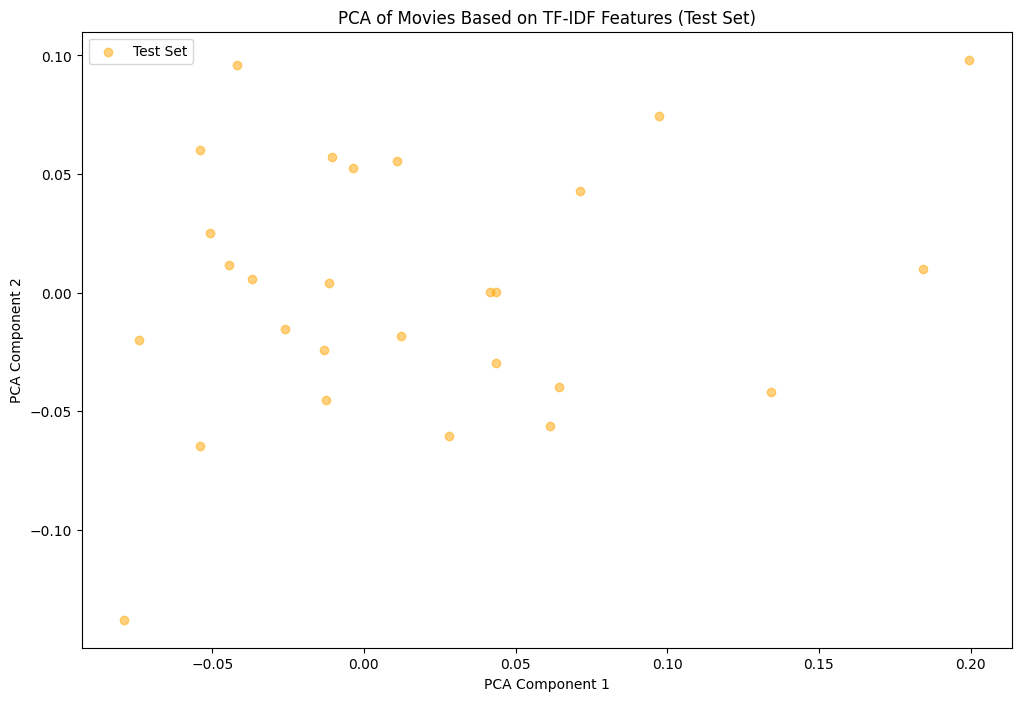


Recommended Movies (Test Set):
                      title  IMDB_Score  Won_Oscar  \
7751                Platoon         0.0       True   
606               The Queen         0.0       True   
7077   Inglourious Basterds         0.0       True   
2317           Total Recall         0.0       True   
7879                  Rocky         0.0       True   
6205                  Babel         0.0       True   
1089  Two Distant Strangers         0.0       True   
6205                  Babel         0.0       True   
8071              Spotlight         0.0       True   
7751                Platoon         0.0       True   
606               The Queen         0.0       True   
7077   Inglourious Basterds         0.0       True   
2317           Total Recall         0.0       True   

                                       listed_in  \
7751  Action & Adventure, Classic Movies, Dramas   
606                 Dramas, International Movies   
7077                          Action & Adventure   
231

In [36]:
# Plotting the PCA result for the test set
plt.figure(figsize=(12, 8))
plt.scatter(tfidf_pca_test[:, 0], tfidf_pca_test[:, 1], alpha=0.5, label='Test Set', color='orange')
plt.title('PCA of Movies Based on TF-IDF Features (Test Set)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()
# Example usage with the test set
recommended_movies_test = recommend_movies_by_category(category, test_set, tfidf_matrix_test, nn)

# Display the recommended movies for the test set
print("\nRecommended Movies (Test Set):")
print(recommended_movies_test)

In [37]:
from sklearn.metrics import pairwise_distances
import numpy as np

def evaluate_model_performance(train_set, test_set, tfidf_matrix_train, tfidf_matrix_test, nn_model):
    # Predict the nearest neighbors for each test sample
    distances, indices = nn_model.kneighbors(tfidf_matrix_test, n_neighbors=10)
    
    # Calculate precision and recall for the recommendations
    precision = []
    recall = []
    
    for i in range(len(test_set)):
        # Get the true category of the test sample
        true_categories = test_set.iloc[i]['listed_in'].split(', ')
        
        # Get the recommended movies
        recommended_indices = indices[i]
        recommended_movies = train_set.iloc[recommended_indices]
        
        # Calculate the number of relevant recommendations
        relevant_recommendations = 0
        for category in true_categories:
            relevant_recommendations += np.sum(recommended_movies['listed_in'].str.contains(category))
        
        # Calculate precision and recall
        precision.append(relevant_recommendations / 10)
        recall.append(relevant_recommendations / len(true_categories))
    
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")

# Evaluate the model's performance on the test set
evaluate_model_performance(train_set, test_set, tfidf_matrix_train, tfidf_matrix_test, nn)


Average Precision: 1.051851851851852
Average Recall: 5.04320987654321


In [7]:
def evaluate_model_performance(test_set, tfidf_matrix_test, nn_model, tfidf):
    # Predict the nearest neighbors for each test sample
    distances, indices = nn_model.kneighbors(tfidf_matrix_test, n_neighbors=10)
    
    # Calculate precision and recall for the recommendations
    y_true = []
    y_pred = []
    
    for i in range(len(test_set)):
        # Get the true categories of the test sample
        true_categories = set(test_set.iloc[i]['listed_in'].split(', '))
        
        # Get the recommended movies
        recommended_indices = indices[i]
        recommended_movies = train_set.iloc[recommended_indices]
        
        # Check the recommended categories
        recommended_categories = set()
        for idx in recommended_indices:
            recommended_categories.update(train_set.iloc[idx]['listed_in'].split(', '))
        
        # Calculate precision and recall
        true_positives = len(true_categories & recommended_categories)
        false_positives = len(recommended_categories - true_categories)
        false_negatives = len(true_categories - recommended_categories)
        
        y_true.append(true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0)
        y_pred.append(true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0)
    
    avg_precision = sum(y_pred) / len(y_pred)
    avg_recall = sum(y_true) / len(y_true)
    
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")
# Evaluate the model's performance on the test set
evaluate_model_performance(test_set, tfidf_matrix_test, nn, tfidf)

# Example usage with the training set
category = "Action"  # The category you want to search for
recommended_movies_train = recommend_movies_by_category(category, train_set, tfidf_matrix_train, nn)

# Display the recommended movies for the training set
print("\nRecommended Movies (Training Set):")
print(recommended_movies_train)

# Example usage with the test set
recommended_movies_test = recommend_movies_by_category(category, test_set, tfidf_matrix_test, nn)

# Display the recommended movies for the test set
print("\nRecommended Movies (Test Set):")
print(recommended_movies_test)


Average Precision: 0.20987736543292101
Average Recall: 0.9753086419753088

Recommended Movies (Training Set):
                                              title  IMDB_Score  Won_Oscar  \
41                                             Jaws         0.0       True   
392                                Django Unchained         0.0       True   
5203                              The Hateful Eight         0.0       True   
8405          The Lord of the Rings: The Two Towers         0.0       True   
8120                                        Sunrise         0.0       True   
...                                             ...         ...        ...   
7330                                    Logan's Run         0.0       True   
7073           Indiana Jones and the Temple of Doom         0.0       True   
1251                             Dances with Wolves         0.0       True   
8404  The Lord of the Rings: The Return of the King         0.0       True   
6056                            